In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#create Spark session
spark = SparkSession.builder.appName('Project').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

# Setup some initial options before you start running the notebook

USE_SUBSET = True

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-cb94d274-a404-433d-b0d5-3fae921ef606;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.4.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.16.0 in central
	found com.google.guava#guava;31.1-jre in centra

In [3]:
econ_data = spark.read.csv("gs://msca-bdp-student-gcs/chicago-economic-data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv", header = True)
taxi_data = spark.read.parquet("gs://msca-bdp-student-gcs/chicago-taxi-trips-data/*.parquet",inferSchema=True)


# First join on pickup_community
df_pickup = taxi_data.join(
    econ_data,
    taxi_data.pickup_community_area == econ_data['Community Area Number'],
    'left'
).select(
    taxi_data["*"],
    *[econ_data[c].alias("pickup_" + c) for c in econ_data.columns if c != 'Community Area Number']
)

# Then join on dropoff_community
df = df_pickup.join(
    econ_data,
    df_pickup.dropoff_community_area == econ_data['Community Area Number'],
    'left'
).select(
    df_pickup["*"],
    *[econ_data[c].alias("dropoff_" + c) for c in econ_data.columns if c != 'Community Area Number']
)

if USE_SUBSET:
    df = df.sample(False,.1)
else:
    pass

In [4]:
df.show(1)

23/11/28 00:05:03 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+--------------------+--------------------+-------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+----+-----+------+----------+------------+--------------------+---------------+----------------+---------------+----------------+-----------------+--------------------+--------------------------+---------------------------------+---------------------------------------+----------------------------------+---------------------------------------------------+---------------------------------------+-------------------------+---------------------+---------------------------+----------------------------------+----------------------------------------+-----------------------------------+----------------------------------------------------+----------------------------------------+--------------------------+----------------------+
|          unique_key|             taxi_id|trip_start_timestamp| trip_en

In [5]:
df.columns

['unique_key',
 'taxi_id',
 'trip_start_timestamp',
 'trip_end_timestamp',
 'trip_seconds',
 'trip_miles',
 'pickup_census_tract',
 'dropoff_census_tract',
 'pickup_community_area',
 'dropoff_community_area',
 'fare',
 'tips',
 'tolls',
 'extras',
 'trip_total',
 'payment_type',
 'company',
 'pickup_latitude',
 'pickup_longitude',
 'pickup_location',
 'dropoff_latitude',
 'dropoff_longitude',
 'dropoff_location',
 'pickup_COMMUNITY AREA NAME',
 'pickup_PERCENT OF HOUSING CROWDED',
 'pickup_PERCENT HOUSEHOLDS BELOW POVERTY',
 'pickup_PERCENT AGED 16+ UNEMPLOYED',
 'pickup_PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
 'pickup_PERCENT AGED UNDER 18 OR OVER 64',
 'pickup_PER CAPITA INCOME ',
 'pickup_HARDSHIP INDEX',
 'dropoff_COMMUNITY AREA NAME',
 'dropoff_PERCENT OF HOUSING CROWDED',
 'dropoff_PERCENT HOUSEHOLDS BELOW POVERTY',
 'dropoff_PERCENT AGED 16+ UNEMPLOYED',
 'dropoff_PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
 'dropoff_PERCENT AGED UNDER 18 OR OVER 64',
 'dropoff_PER CAP

In [6]:
df.printSchema()

root
 |-- unique_key: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_census_tract: long (nullable = true)
 |-- dropoff_census_tract: long (nullable = true)
 |-- pickup_community_area: long (nullable = true)
 |-- dropoff_community_area: long (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- drop

In [7]:
df.describe().show()

+-------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+---------------------+----------------------+------------------+------------------+-------------------+------------------+-----------------+------------+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------------+---------------------------------+---------------------------------------+----------------------------------+---------------------------------------------------+---------------------------------------+-------------------------+---------------------+---------------------------+----------------------------------+----------------------------------------+-----------------------------------+----------------------------------------------------+----------------------------------------+--------------------------+----------------------+
|summary|  

NA Analysis

In [8]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, count, lit, sum as _sum



def get_null_percentage(df:DataFrame,sample = 1.0) -> DataFrame:
    
    df_ = df.sample(False, sample) # Sample our DataFrame
    
    # Get a dictionary of each column and their null percentage
    null_percentage = df_.select([
        (_sum(col(c).isNull().cast("int")) / count(lit(1)) * 100).alias(c)
        for c in df_.columns
    ])
    
    # Collect data as a Python dictionary
    null_percentage_dict = {row[0]: row[1] for row in null_percentage.head().asDict().items()}

    return null_percentage_dict

get_null_percentage(df, 1.0)

{'unique_key': 0.0,
 'taxi_id': 0.0,
 'trip_start_timestamp': 0.0,
 'trip_end_timestamp': 0.00880060520062603,
 'trip_seconds': 0.6191420378280771,
 'trip_miles': 0.0013148692775476862,
 'pickup_census_tract': 36.697166095948525,
 'dropoff_census_tract': 37.14655708599905,
 'pickup_community_area': 11.459484486749796,
 'dropoff_community_area': 13.527712151665853,
 'fare': 0.008392378637921694,
 'tips': 0.008392378637921694,
 'tolls': 15.612031538065253,
 'extras': 0.008392378637921694,
 'trip_total': 0.008392378637921694,
 'payment_type': 0.0,
 'company': 15.944560554310913,
 'pickup_latitude': 11.446682311870568,
 'pickup_longitude': 11.446682311870568,
 'pickup_location': 11.446682311870568,
 'dropoff_latitude': 13.271023086493763,
 'dropoff_longitude': 13.271023086493763,
 'dropoff_location': 13.271023086493763,
 'pickup_COMMUNITY AREA NAME': 11.459484486749796,
 'pickup_PERCENT OF HOUSING CROWDED': 11.459484486749796,
 'pickup_PERCENT HOUSEHOLDS BELOW POVERTY': 11.459484486749796,

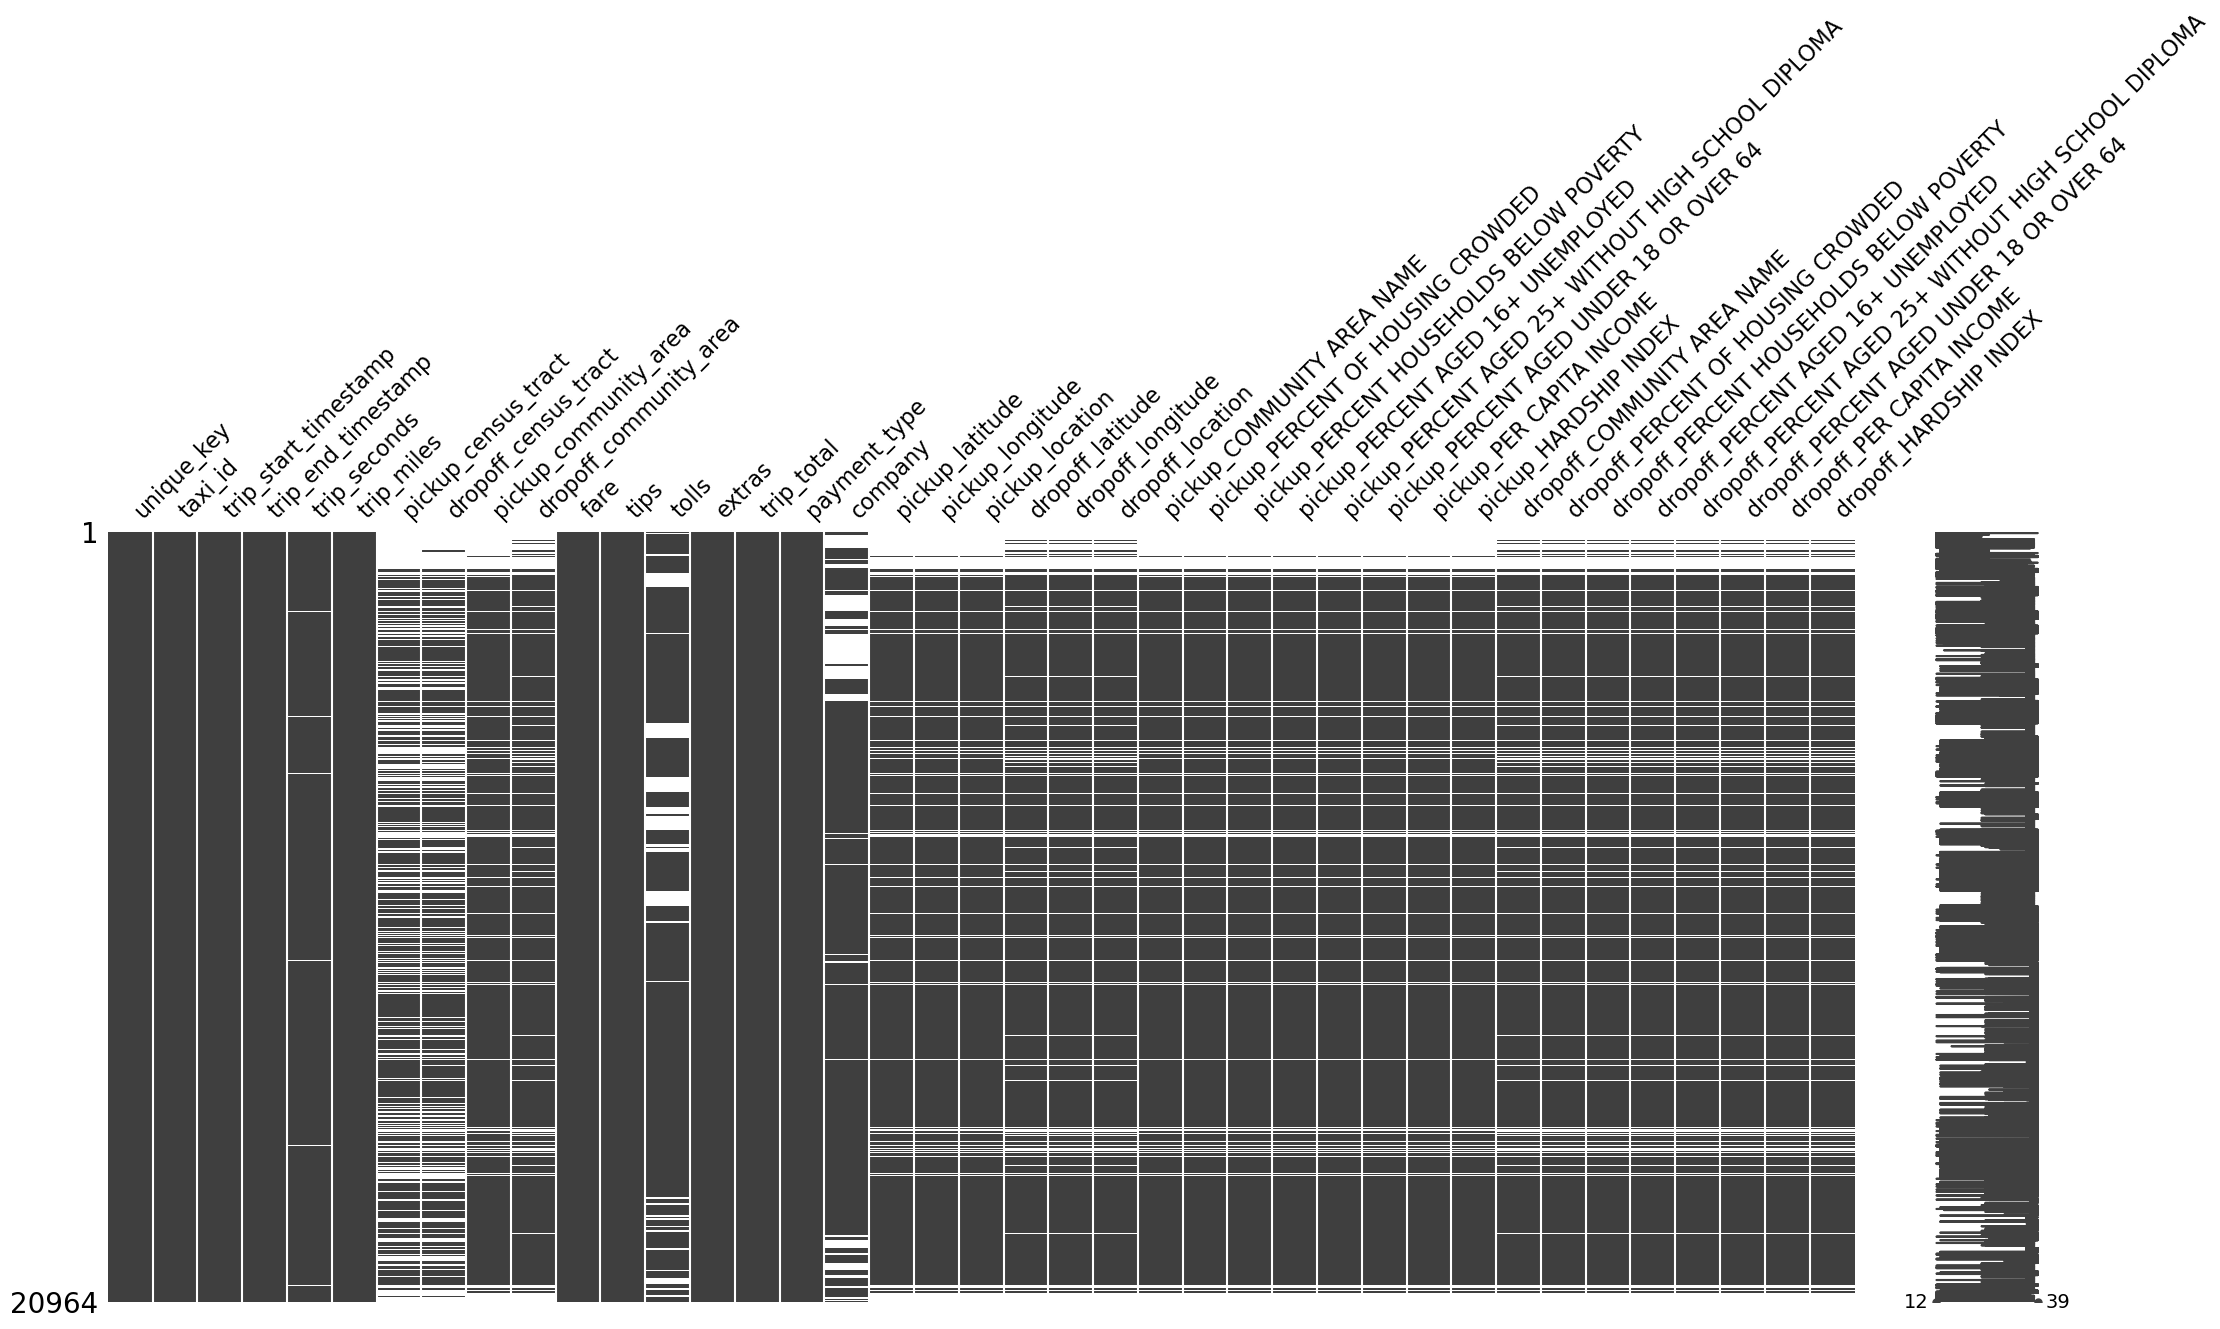

In [9]:
import missingno as msno
import matplotlib.pyplot as plt
from pyspark.sql import DataFrame

def missingno_subset(df: DataFrame, sample_ratio=1.0, columns=None) -> None:
    # Sample the DataFrame
    df_sampled = df.sample(False, sample_ratio)

    # Select specified columns if provided
    if columns:
        df_sampled = df_sampled.select(columns)

    # Convert to Pandas DataFrame for visualization
    pandas_df = df_sampled.toPandas()

    # Generate missingno chart
    msno.matrix(pandas_df)
    plt.show()
    
missingno_subset(df, sample_ratio = .001)

In [10]:
from pyspark.sql import DataFrame

def showPandas(df: DataFrame, n: int = 20) -> None:
    pandas_df = df.limit(n).toPandas()  # Convert to Pandas DataFrame with limit
    display(pandas_df)  # Display the Pandas DataFrame
    
showPandas(df)


,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,pickup_PER CAPITA INCOME,pickup_HARDSHIP INDEX,dropoff_COMMUNITY AREA NAME,dropoff_PERCENT OF HOUSING CROWDED,dropoff_PERCENT HOUSEHOLDS BELOW POVERTY,dropoff_PERCENT AGED 16+ UNEMPLOYED,dropoff_PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,dropoff_PERCENT AGED UNDER 18 OR OVER 64,dropoff_PER CAPITA INCOME,dropoff_HARDSHIP INDEX
0,660e1adc36cc0bf74b5c1eb805a8a079bf32849c,05d385bde54ef510a1263c58489dd9a0a06048c04b3411...,2017-07-21 11:45:00,2017-07-21 12:15:00,1200,14.2,NaN,NaN,NaN,76.0,...,None,None,O'Hare,3.6,15.4,7.1,10.9,30.3,25828,24
1,8bc4990e1bfc055828aaf610321cb60437f3f2eb,864e0bed592c7a476208dbb4d719f853c84d7d5e8d322a...,2017-07-23 16:45:00,2017-07-23 16:45:00,0,0.0,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
2,d89b63f79e8343522b856b85ad0cacb715147d63,ba5412a204ac0bee645a854a7eb69abd3df912fbaa9857...,2016-03-17 12:30:00,2016-03-17 12:30:00,540,1.5,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
3,899f4aa5d91f831b57550ca78aeb5dd2fa801ef9,f8aaba3ff959b9768365b91e3bd4e7ea430ae6ae8da958...,2017-07-21 21:45:00,2017-07-21 22:00:00,180,0.6,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
4,7f4439777fbb8ad02c12b7894c4794e04f90b38e,50594e8c21065b9d0c3b3926d36ecaf7fb777634a0346f...,2017-07-21 19:15:00,2017-07-21 19:15:00,0,0.0,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
5,b3e1ea11999fbac7d1c3a9b464092e4d15e3f629,502a000e4ee99c96dc9964f2994671b57b73fd6902e234...,2017-07-21 13:45:00,2017-07-21 14:00:00,540,0.0,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
6,78d68f7a49a417a7605a8eaead1001c768e060bd,687e3ef9daf087b79188bf0fea27f22cd5786b0cda0c80...,2017-07-21 23:00:00,2017-07-21 23:00:00,0,0.0,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
7,57b9cea0f191ac219e012940cd86bea26fc78daf,774c16d2c0c72290e3a9071249c0aabbc14ac4400b2008...,2016-03-16 22:45:00,2016-03-16 22:45:00,540,1.7,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
8,132a53cf97d5be8fef1e55a446eb8b7d09e89798,57dbcc9d59c0730235c8d003188f5e4a109acd35a61266...,2017-07-22 10:30:00,2017-07-22 10:45:00,1080,0.4,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
9,49201822712d7b935843dd7b147920949585771d,774c16d2c0c72290e3a9071249c0aabbc14ac4400b2008...,2016-03-16 18:30:00,2016-03-16 18:45:00,1680,8.2,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


It appears that we can just drop the rows that have null values

In [11]:
df = df.dropna()

# Feature Engineering and EDA

In [12]:
# We want this to be both a classification and regression problem
df = df.withColumn("tip_is_0", F.when(F.col("tips") == 0, 1).otherwise(0))

df = df.withColumn("tip_per_second*1000", F.when(F.col("trip_seconds") != 0, F.col("tips") / F.col("trip_seconds") * 1000).otherwise(0))

In [26]:
from pyspark.sql.functions import mean, stddev

mean_value = df.agg(stddev("tip_per_second").alias("mean")).collect()[0]["mean"]


In [13]:
binary_pd = df.select("tip_is_0").toPandas()
binary_pd.hist()

array([[<AxesSubplot:title={'center':'tip_per_second'}>]], dtype=object)

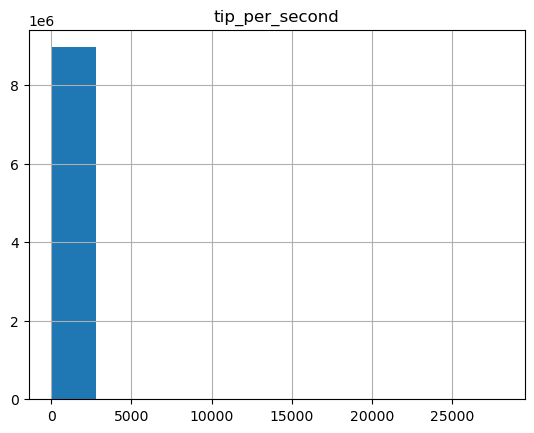

In [15]:
binary_pd = df.select("tip_per_second").toPandas()

(array([296., 474., 345., 391., 319., 343., 304., 557., 211., 267., 173.,
        298., 162., 215., 132., 111., 294.,  83., 109., 114., 188.,  73.,
        106., 112.,  58., 291.,  59.,  62.,  80.,  65.,  98.,  85.,  53.,
        130.,  58.,  58.,  92.,  47.,  66.,  28.,  32.,  23.,  42.,  18.,
        229.,  56.,  53.,  24.,  31.,  23.,  48.,  20.,  30.,  29.,  26.,
         50.,  17.,  52.,  57.,  29.,  30.,  11.,  14.,  81.,  34.,  22.,
         18.,  10.,  39.,  28.,  19.,  16.,  72.,  39.,  28.,  63.,  13.,
         33.,  19.,  11.,  36.,  78.,  13.,  45.,  12.,  10.,  19.,  12.,
         17.,  17.,  15.,  16.,  15.,  13.,   8.,   7.,  11.,  10.,  10.,
          4.]),
 array([100.10869565, 109.0976087 , 118.08652174, 127.07543478,
        136.06434783, 145.05326087, 154.04217391, 163.03108696,
        172.02      , 181.00891304, 189.99782609, 198.98673913,
        207.97565217, 216.96456522, 225.95347826, 234.9423913 ,
        243.93130435, 252.92021739, 261.90913043, 270.89804348

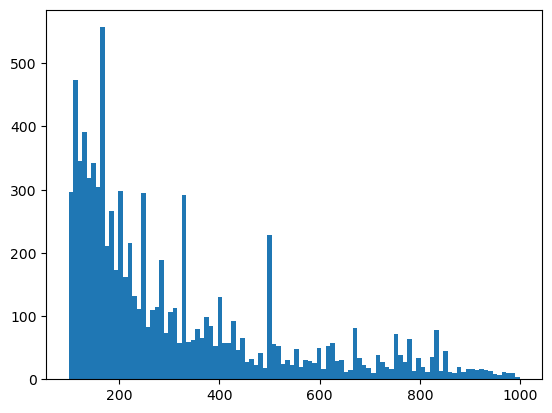

In [38]:
import matplotlib.pyplot as plt
df1 = binary_pd[binary_pd["tip_per_second"] > 100]
df1 = df1[df1["tip_per_second"] < 1000]

plt.hist(df1, bins = 100)

In [39]:
# Create some new features from the existing ones

df = df.withColumn("trip_duration_hours", (col("trip_seconds") / 3600))

# Calculate average speed in miles per hour
df = df.withColumn("average_speed_mph", col("trip_miles") / col("trip_duration_hours"))

# Calculate income difference
df = df.withColumn("income_difference", col("pickup_PER CAPITA INCOME ") - col("dropoff_PER CAPITA INCOME "))

# Calculate hardship index difference
df = df.withColumn("hardship_index_difference", col("pickup_HARDSHIP INDEX") - col("dropoff_HARDSHIP INDEX"))

# Calculate percentage differences for a specific feature (example: Percent of Housing Crowded)
df = df.withColumn("percent_housing_crowded_diff", col("pickup_PERCENT OF HOUSING CROWDED") - col("dropoff_PERCENT OF HOUSING CROWDED"))

Create a pickup and dropoff relationship chart

In [45]:
# Find top 5 pickup locations
top_pickup_locations = df.groupBy("pickup_COMMUNITY AREA NAME").count().orderBy(desc("count")).limit(5)

# Find top 5 dropoff locations
top_dropoff_locations = df.groupBy("dropoff_COMMUNITY AREA NAME").count().orderBy(desc("count")).limit(5)

# Filter trips that start and end at these top locations
filtered_trips = df.join(top_pickup_locations, "pickup_COMMUNITY AREA NAME").join(top_dropoff_locations, "dropoff_COMMUNITY AREA NAME")

# Count trips for each pickup-dropoff pair
trip_counts = filtered_trips.groupBy("pickup_COMMUNITY AREA NAME", "dropoff_COMMUNITY AREA NAME").count()

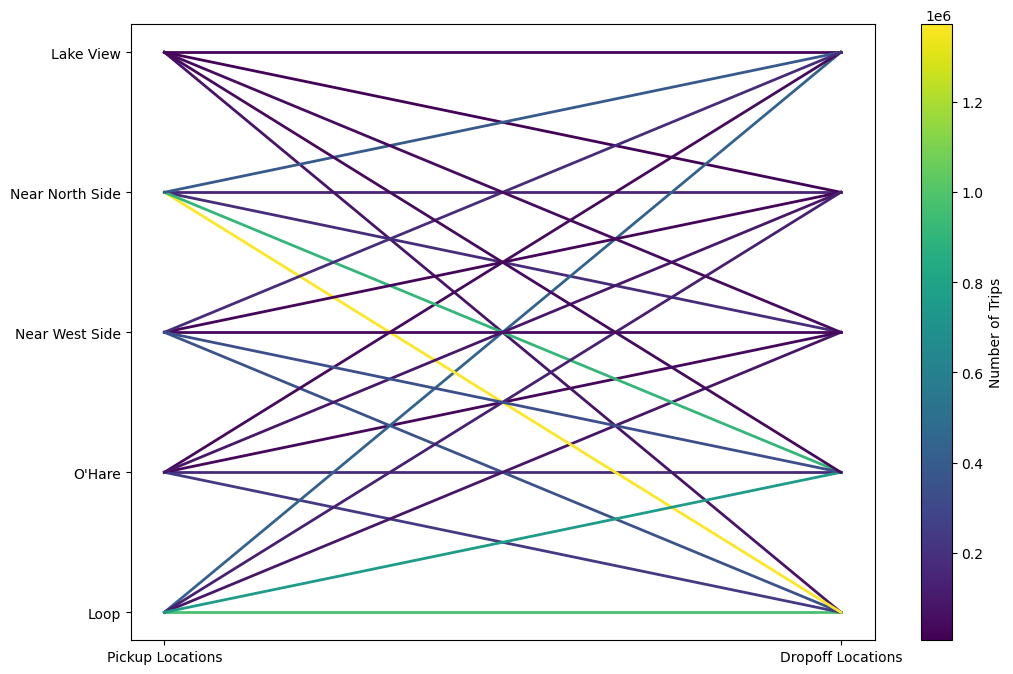

In [47]:
trip_counts_pd = trip_counts.toPandas()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Unique pickup and dropoff locations
pickup_locations = trip_counts_pd['pickup_COMMUNITY AREA NAME'].unique()
dropoff_locations = trip_counts_pd['dropoff_COMMUNITY AREA NAME'].unique()

# Plotting each trip
for _, row in trip_counts_pd.iterrows():
    pickup_idx = list(pickup_locations).index(row['pickup_COMMUNITY AREA NAME'])
    dropoff_idx = list(dropoff_locations).index(row['dropoff_COMMUNITY AREA NAME'])
    ax.plot([1, 2], [pickup_idx, dropoff_idx], color=plt.cm.viridis(row['count']/trip_counts_pd['count'].max()), lw=2)

# Setting labels for pickup and dropoff locations
ax.set_xticks([1, 2])
ax.set_xticklabels(['Pickup Locations', 'Dropoff Locations'])
ax.set_yticks(range(len(pickup_locations)))
ax.set_yticklabels(pickup_locations)
ax.set_yticks(range(len(dropoff_locations)), minor=True)
ax.set_yticklabels(dropoff_locations, minor=True)

# Show color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=trip_counts_pd['count'].min(), vmax=trip_counts_pd['count'].max()))
cbar = plt.colorbar(sm)
cbar.set_label('Number of Trips')

plt.show()

# Modeling Part